<a href="https://colab.research.google.com/github/akhilesh008/AIML-Training-Akhilesh/blob/main/Pretrained.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import packages
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, SubsetRandomSampler
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import time
import os

In [2]:
# Device configuration (whether to run on GPU or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Download and extract dataset
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip -q hymenoptera_data.zip

--2023-10-03 17:01:49--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 18.164.154.30, 18.164.154.17, 18.164.154.123, ...
Connecting to download.pytorch.org (download.pytorch.org)|18.164.154.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M   160MB/s    in 0.3s    

2023-10-03 17:01:50 (160 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]



In [4]:
# Data augmentation and normalization for training
# Just normalization for validation
train_transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
val_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

data_dir = './hymenoptera_data'
train_dataset = ImageFolder(os.path.join(data_dir, 'train'), train_transform)
val_dataset = ImageFolder(os.path.join(data_dir, 'val'), val_transform)
train_dataloader = DataLoader(train_dataset, batch_size=4,shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=4,shuffle=True, num_workers=2)
class_names = train_dataset.classes

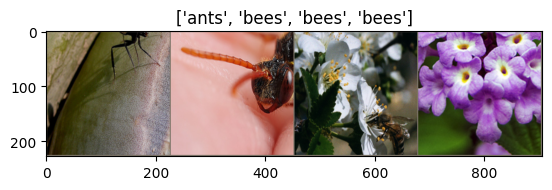

In [5]:
import numpy as np
import matplotlib.pyplot as plt
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(train_dataloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [6]:
def train_model(model, train_dataloader, criterion, optimizer, num_epochs=25):

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        model.train()
        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for i, (inputs, labels) in enumerate(train_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(True):
              outputs = model(inputs)
              _, preds = torch.max(outputs, 1)
              loss = criterion(outputs, labels)

              # backward + optimize only if in training phase
              loss.backward()
              optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_dataloader.dataset)
        epoch_acc = running_corrects.double() / len(train_dataloader.dataset)

        print(f'Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        print()

In [7]:
def visualize_model(model, num_images=10):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(val_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [8]:
from torchvision import models

model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

loss_func = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 123MB/s]


In [9]:
num_epochs = 5
train_model(model_ft, train_dataloader, loss_func, optimizer, num_epochs)

Epoch 0/4
----------
Loss: 0.5342 Acc: 0.6926

Epoch 1/4
----------
Loss: 0.5891 Acc: 0.7951

Epoch 2/4
----------
Loss: 0.5383 Acc: 0.7992

Epoch 3/4
----------
Loss: 0.6875 Acc: 0.7131

Epoch 4/4
----------
Loss: 0.4776 Acc: 0.8238



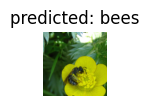

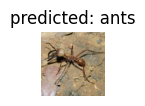

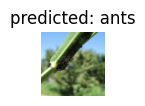

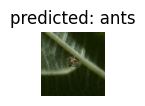

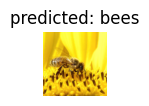

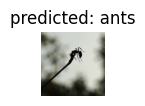

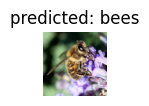

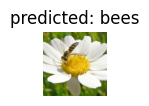

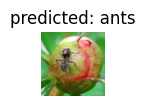

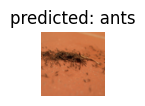

In [10]:
visualize_model(model_ft)

In [12]:
from PIL import Image
def visualize_model_predictions(model,img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = val_transform(img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0]]}')
        imshow(img.cpu().data[0])

        model.train(mode=was_training)

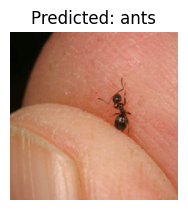

In [13]:
visualize_model_predictions(
    model_ft,
    img_path='ant_1.jpg'
)

plt.ioff()
plt.show()

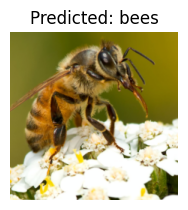

In [18]:
visualize_model_predictions(
    model_ft,
    img_path='bee2.jpg'
)

plt.ioff()
plt.show()

In [20]:
# Change learning rate
optimizer = optim.SGD(model_ft.parameters(), lr=0.0001, momentum=0.9)

In [21]:
num_epochs = 10
train_model(model_ft, train_dataloader, loss_func, optimizer, num_epochs)

Epoch 0/9
----------
Loss: 0.4021 Acc: 0.8197

Epoch 1/9
----------
Loss: 0.3281 Acc: 0.8525

Epoch 2/9
----------
Loss: 0.2424 Acc: 0.9180

Epoch 3/9
----------
Loss: 0.2289 Acc: 0.8934

Epoch 4/9
----------
Loss: 0.2342 Acc: 0.9098

Epoch 5/9
----------
Loss: 0.2882 Acc: 0.8689

Epoch 6/9
----------
Loss: 0.3412 Acc: 0.8525

Epoch 7/9
----------
Loss: 0.2952 Acc: 0.8730

Epoch 8/9
----------
Loss: 0.3572 Acc: 0.8402

Epoch 9/9
----------
Loss: 0.2986 Acc: 0.8893



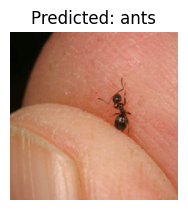

In [22]:
visualize_model_predictions(
    model_ft,
    img_path='ant_1.jpg'
)

plt.ioff()
plt.show()

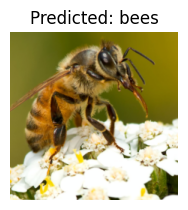

In [25]:
visualize_model_predictions(
    model_ft,
    img_path='bee2.jpg'
)

plt.ioff()
plt.show()

### Change momentum

In [26]:
optimizer = optim.SGD(model_ft.parameters(), lr=0.0001, momentum=0.95)

In [27]:
num_epochs = 5
train_model(model_ft, train_dataloader, loss_func, optimizer, num_epochs)

Epoch 0/4
----------
Loss: 0.2636 Acc: 0.8934

Epoch 1/4
----------
Loss: 0.3044 Acc: 0.8607

Epoch 2/4
----------
Loss: 0.3174 Acc: 0.8689

Epoch 3/4
----------
Loss: 0.2823 Acc: 0.8811

Epoch 4/4
----------
Loss: 0.2822 Acc: 0.8893



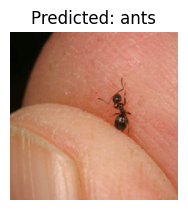

In [28]:
visualize_model_predictions(
    model_ft,
    img_path='ant_1.jpg'
)

plt.ioff()
plt.show()